# LoFTR Test

In [3]:
import os
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import torch
from kornia_moons.viz import draw_LAF_matches
import skimage as ski
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [4]:
from loftr import load_resize_image, loftr_match, plot_matches, plot_matches_conf, plot_match_coverage, tps_skimage, plot_img_transform, plot_overlay, ncc, mutual_information, crop_margins

In [27]:
img_folder = "../leaf-image-sequences/processed/reg/ESWW0070020_1/crop/"
img1_path = img_folder + "20230525_172420_ESWW0070020_1.JPG"
img2_path = img_folder + "20230527_102010_ESWW0070020_1.JPG"
img_last_path = img_folder + "20230608_162957_ESWW0070020_1.JPG"

assert os.path.exists(img1_path) and os.path.exists(img2_path) and os.path.exists(img_last_path), "Invalid path to images"

img1 = load_resize_image(img1_path, H=256, W=1024)
img2 = load_resize_image(img2_path, H=256, W=1024)
img_last = load_resize_image(img_last_path, H=256, W=1024)

print(f"Img size: {(img1.nelement() * img1.element_size())/1000000} MB")

Img size: 3.145728 MB


## Match first and second image

In [28]:
# match with LoFTR
mkpts1, mkpts2, confidence, inliers = loftr_match(img1, img2)

Total matches: 1246
Matches with Confidence > 0.5: 796
Inliers: 704 (56.50%)


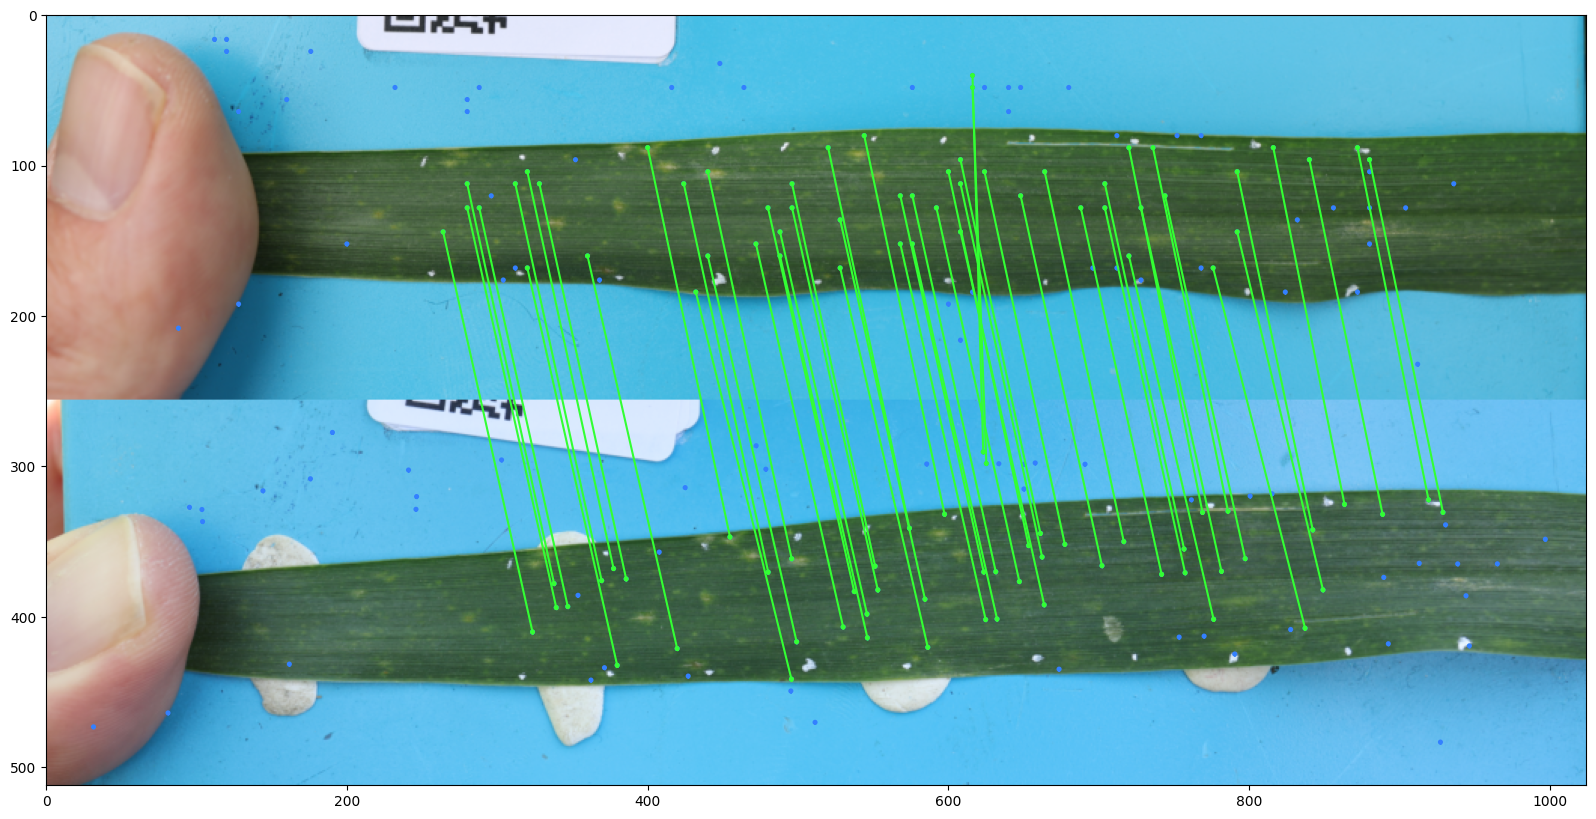

In [29]:
# plot matches
fig, ax = plot_matches(img1, mkpts1, img2, mkpts2, inliers, inliers_only=False)
fig.show()

## Plot Confidence

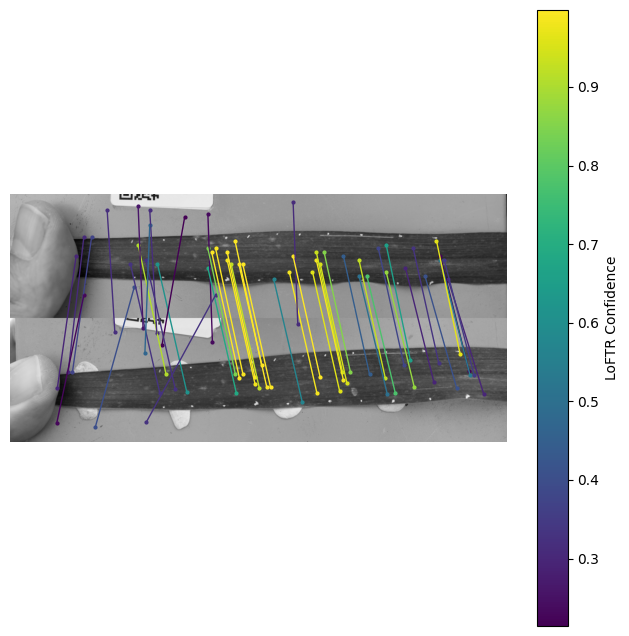

In [30]:
fig, ax = plot_matches_conf(img1, mkpts1, img2, mkpts2, confidence, N_show=50, vertical=True)
fig.show()

## Plot Spatial Coverage

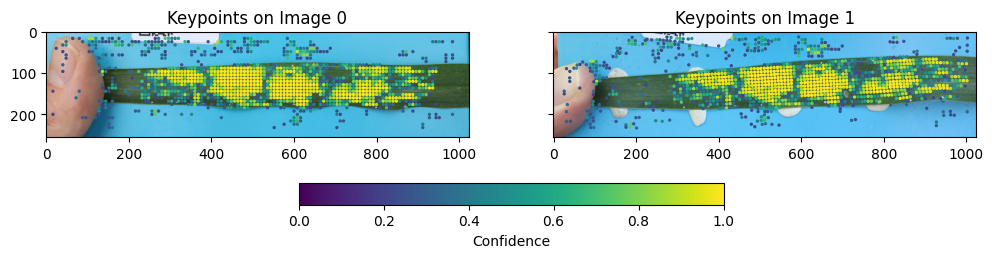

In [31]:
fig, axs = plot_match_coverage(img1, mkpts1, img2, mkpts2, confidence)
fig.show()

## Thin Plate Spline

In [32]:
thrsld = 0.75
print(f"Remaining Keypoints: {mkpts1[confidence > thrsld].shape[0]}")

Remaining Keypoints: 550


In [33]:
img1_mks = mkpts1[confidence > thrsld]
img2_mks = mkpts2[confidence > thrsld]
warped, tps = tps_skimage(mkpts1, mkpts2, confidence, thrsld, img2)

In [34]:
tps_inv = ski.transform.ThinPlateSplineTransform()
tps_inv.estimate(img2_mks, img1_mks) # estimate transform from img2 → img1
warped_keypts = tps_inv(img2_mks)

In [35]:
warped_keypts.shape

(550, 2)

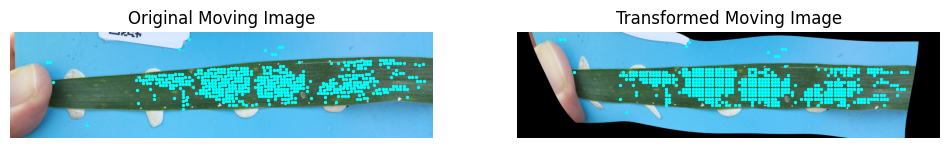

In [36]:
# plot original + warped moving image
fig, axs = plot_img_transform(img2, warped, plot_keypts=True, keypts_mov=img2_mks, keypts_warped=warped_keypts)
fig.show()

### Overlay

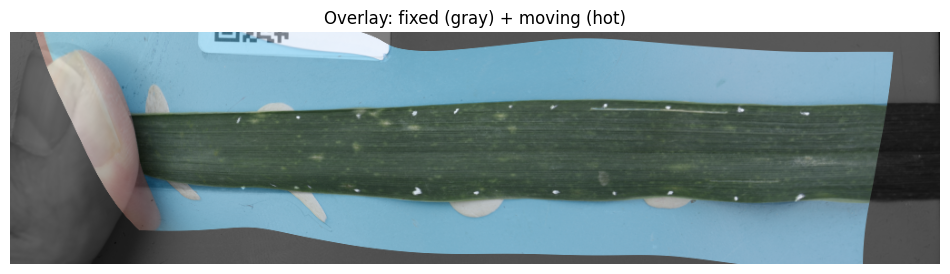

In [37]:
fig = plot_overlay(img1, warped)
fig.show()

### Metrics

#### Keypoint Alignment

In [49]:
# Image 1 keypoints vs warped keypoints of image 2:
mae_12 = np.mean(np.abs(img1_mks.numpy() - warped_keypts))
print(f"Alignment Error of Keypoints of Image 1 vs Warped Keypoints of Image 2:    {mae_12:.5} (MAE)")

# Image 2 keypoints vs warped keypoints of image 1:
warped_keypts_img1 = tps(img1_mks)
mae_21 = np.mean(np.abs(img2_mks.numpy() - warped_keypts_img1))
print(f"Alignment Error of Keypoints of Image 2 vs Warped Keypoints of Image 1:    {mae_21:.5} (MAE)")

Alignment Error of Keypoints of Image 1 vs Warped Keypoints of Image 2:    0.0015339 (MAE)
Alignment Error of Keypoints of Image 2 vs Warped Keypoints of Image 1:    0.0017954 (MAE)


#### MSE & SSIM

In [39]:
img1_np = K.tensor_to_image(img1)
mse_12 = mean_squared_error(img1_np, warped)
ssim_12, ssim_img = ssim(img1_np, warped, channel_axis=-1, data_range=(warped.max() - warped.min()), full=True) 
# NOTE: there's also a kornia version of this loss: kornia.losses.ssim_loss or kornia.metrics.ssim
print(f"MSE: {mse_12:.5f}")
print(f"SSIM: {ssim_12:.5f}")
# plt.imshow(ssim_img)

MSE: 0.10141
SSIM: 0.59900


### NCC & MI

In [40]:
ncc_12 = ncc(img1, warped)
print(f"NCC = {ncc_12:.5f}") # higher/closer to 1 is better

NCC = 0.26933


In [41]:
mi = mutual_information(img1, warped)
print(f"Mutual Information = {mi:.5f}")

Mutual Information = 0.72871


## First vs Last Image

In [42]:
# match with LoFTR
mkpts_0, mkpts_l, confidence_l, inliers_l = loftr_match(img1, img_last)

Total matches: 261
Matches with Confidence > 0.5: 46
Inliers: 52 (19.92%)


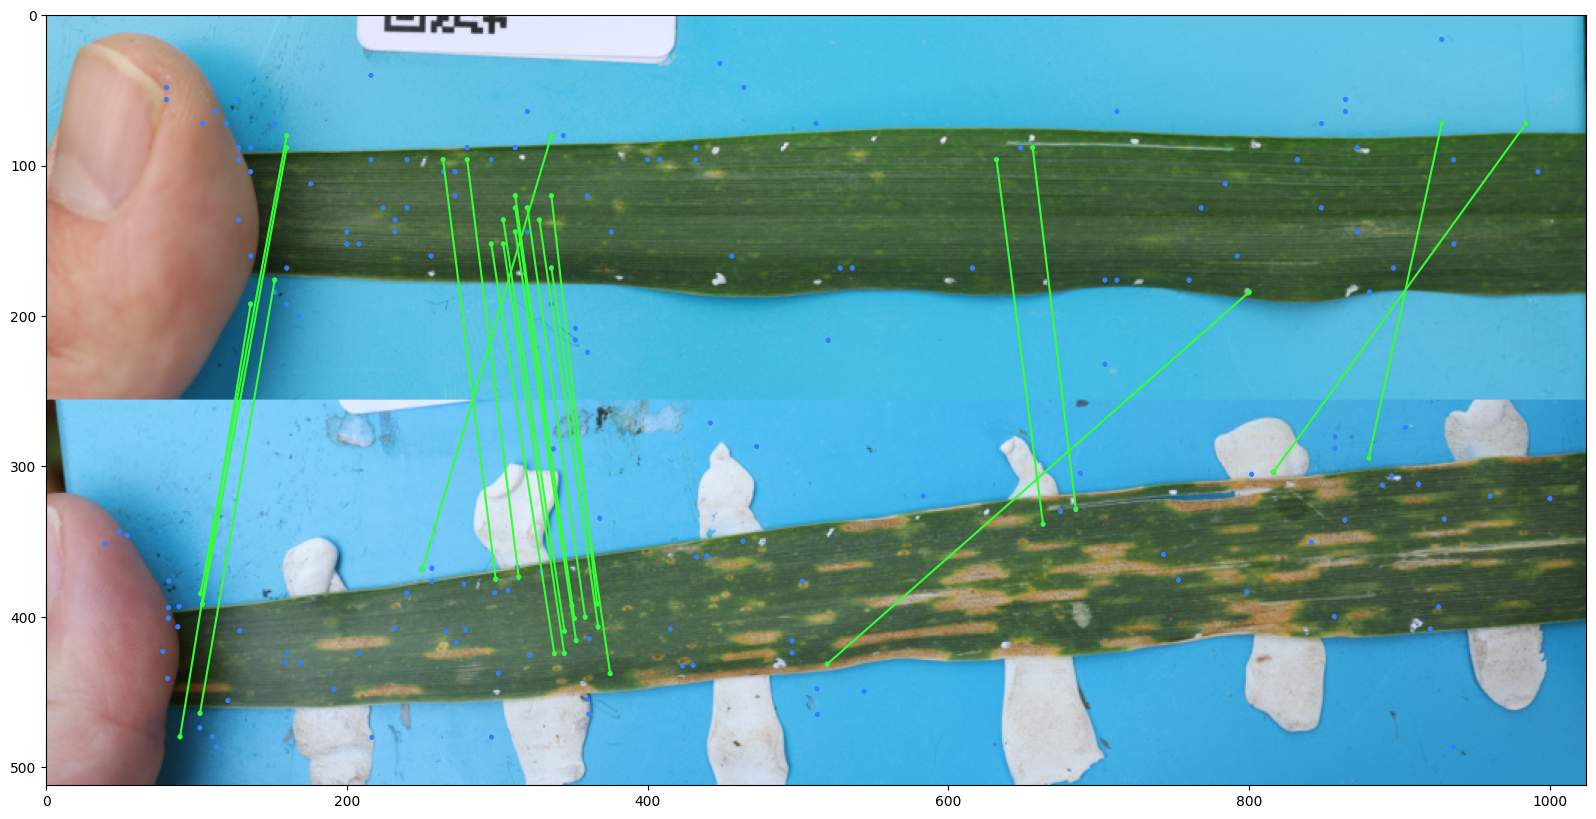

In [43]:
# plot matches
fig, ax = plot_matches(img1, mkpts_0, img_last, mkpts_l, inliers_l, inliers_only=False)
fig.show()

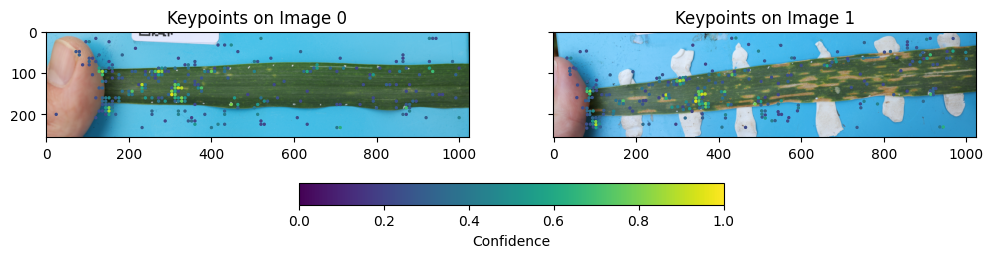

In [44]:
# plot covergae
fig, axs = plot_match_coverage(img1, mkpts_0, img_last, mkpts_l, confidence_l)
fig.show()

### TPS

In [45]:
img_0_mks = mkpts_0[confidence_l > thrsld]
img_l_mks = mkpts_l[confidence_l > thrsld]
warped_l, tps_l = tps_skimage(mkpts_0, mkpts_l, confidence_l, thrsld, img_last)

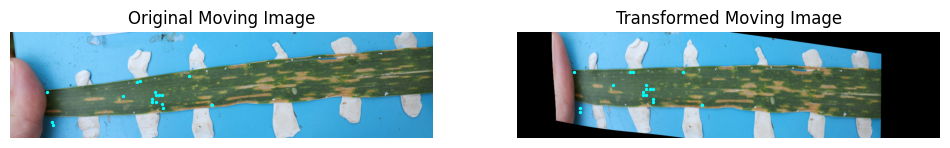

In [46]:
# plot original + warped moving image
fig, axs = plot_img_transform(img_last, warped_l, plot_keypts=True, keypts_mov=img_l_mks, keypts_warped=img_0_mks)
fig.show()

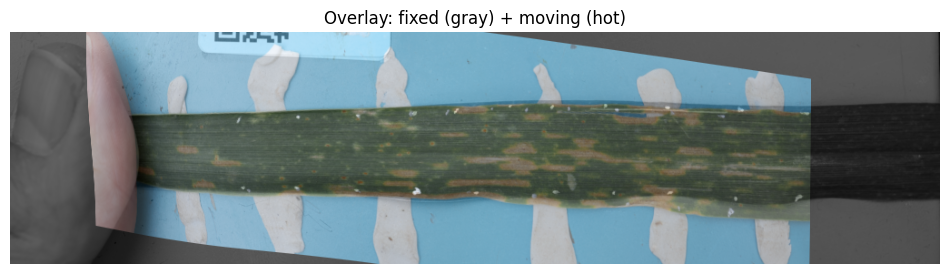

In [47]:
fig = plot_overlay(img1, warped_l)
fig.show()

In [51]:
# Image 2 keypoints vs warped keypoints of image 1:
warped_keypts_img1 = tps_l(img_0_mks)
mae_l1 = np.mean(np.abs(img_l_mks.numpy() - warped_keypts_img1))
print(f"Alignment Error of Keypoints of Last Image vs Warped Keypoint of Image 1:    {mae_l1:.5} (MAE)")

Alignment Error of Keypoints of Last Image vs Warped Keypoint of Image 1:    2.3677e-05 (MAE)


In [52]:
img1_np = K.tensor_to_image(img1)
mse_1l = mean_squared_error(img1_np, warped_l)
ssim_1l, ssim_img = ssim(img1_np, warped_l, channel_axis=-1, data_range=(warped.max() - warped.min()), full=True) 
# NOTE: there's also a kornia version of this loss: kornia.losses.ssim_loss or kornia.metrics.ssim
print(f"MSE: {mse_1l:.5f}")
print(f"SSIM: {ssim_1l:.5f}")
# plt.imshow(ssim_img)
ncc_1l = ncc(img1, warped_l)
print(f"NCC = {ncc_1l:.5f}") # higher/closer to 1 is better
mi_1l = mutual_information(img1, warped_l)
print(f"Mutual Information = {mi_1l:.5f}")

MSE: 0.12743
SSIM: 0.39959
NCC = 0.17958
Mutual Information = 0.58147


## Crop Testing

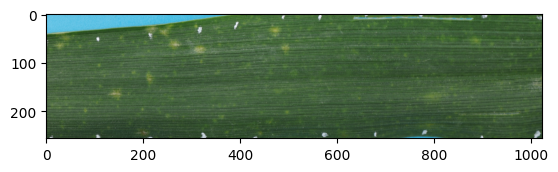

In [80]:
img_roi_folder = "../leaf-image-sequences/processed/reg/ESWW0070020_1/result/piecewise/"
img1_roi_path = img_roi_folder + "20230525_172420_ESWW0070020_1.JPG"
img2_roi_path = img_roi_folder + "20230527_102010_ESWW0070020_1.JPG"
imgl_roi_path = img_roi_folder + "20230608_162957_ESWW0070020_1.JPG"

assert os.path.exists(img1_roi_path) and os.path.exists(img2_roi_path) and os.path.exists(imgl_roi_path), "Invalid path to images"

img1_roi = load_resize_image(img1_roi_path, H=256, W=1024)
img2_roi = load_resize_image(img2_roi_path, H=256, W=1024)
imgl_roi = load_resize_image(imgl_roi_path, H=256, W=1024)
plt.imshow(K.tensor_to_image(img1_roi))

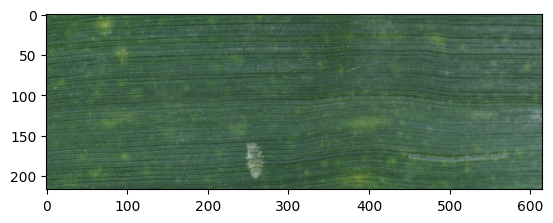

In [86]:
# margins to cut off
top = 20
bottom = 20
left = 400
right = 10

cropped_1 = crop_margins(img1_roi, top, bottom, left, right)
plt.imshow(K.tensor_to_image(cropped_1))

cropped_2 = crop_margins(img2_roi, top, bottom, left, right)
plt.imshow(K.tensor_to_image(cropped_2))


Total matches: 1543
Matches with Confidence > 0.5: 1326
Inliers: 613 (39.73%)


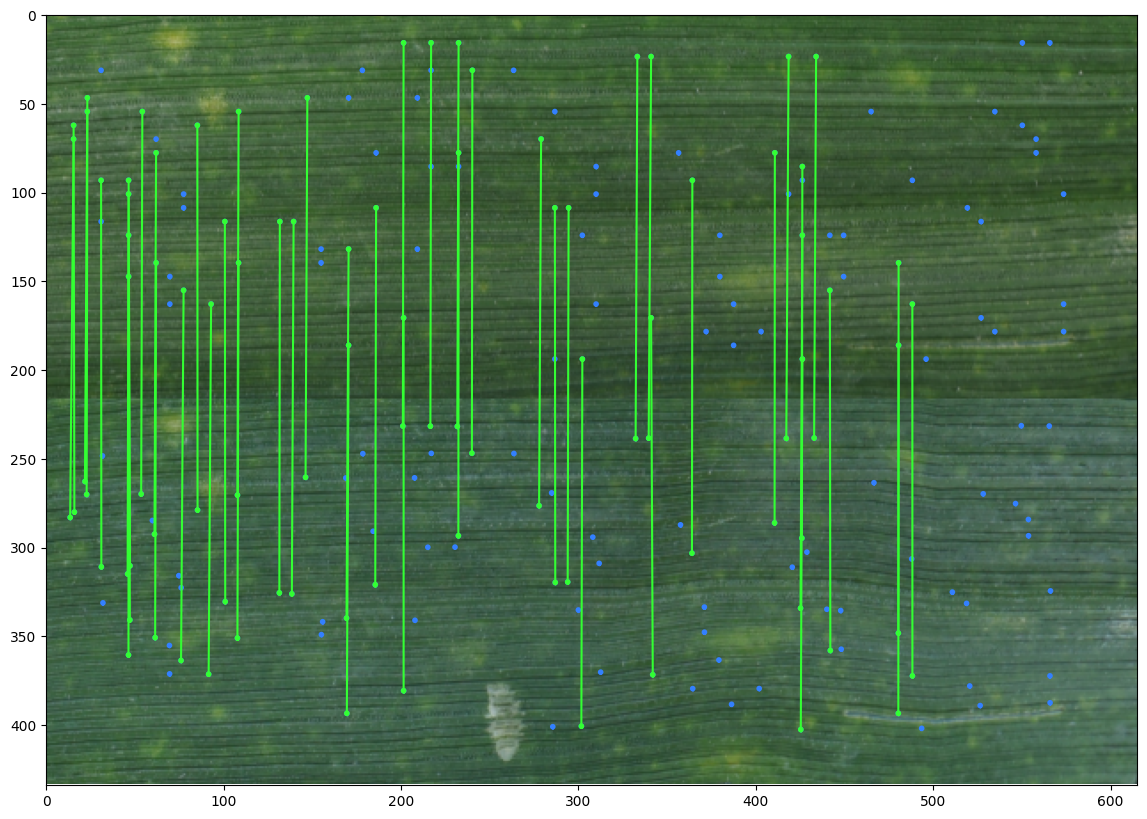

In [87]:
mkpts1, mkpts2, confidence, inliers = loftr_match(cropped_1, cropped_2)
fig, ax = plot_matches(cropped_1, mkpts1, cropped_2, mkpts2, inliers, inliers_only=False)
fig.show()

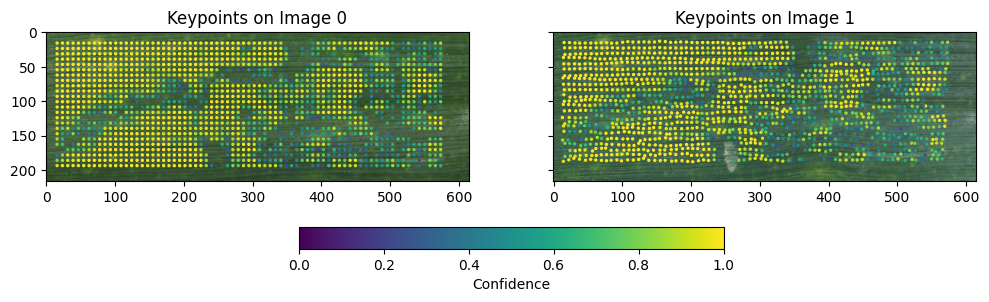

In [88]:
fig, axs = plot_match_coverage(cropped_1, mkpts1, cropped_2, mkpts2, confidence)
fig.show()

## Time series

In [7]:
## Time series
img_roi_folder = "../leaf-image-sequences/processed/reg/ESWW0070020_1/result/piecewise/"
first_path = img_roi_folder + "20230525_172420_ESWW0070020_1.JPG"

first = load_resize_image(first_path, H=256, W=1024)

top = 20
bottom = 20
left = 400
right = 10

first = crop_margins(first, top, bottom, left, right)


paths = ["20230527_102010_ESWW0070020_1.JPG", "20230527_164909_ESWW0070020_1.JPG", "20230529_122541_ESWW0070020_1.JPG", "20230530_122548_ESWW0070020_1.JPG", "20230531_094332_ESWW0070020_1.JPG", "20230531_164152_ESWW0070020_1.JPG", "20230601_155601_ESWW0070020_1.JPG", "20230602_104754_ESWW0070020_1.JPG", "20230603_105040_ESWW0070020_1.JPG", "20230604_132542_ESWW0070020_1.JPG", "20230606_084622_ESWW0070020_1.JPG", "20230607_162917_ESWW0070020_1.JPG", "20230608_162957_ESWW0070020_1.JPG"]
n_matches = np.zeros(len(paths))
n_conf_matches = np.zeros(len(paths))
n_inliers = np.zeros(len(paths))


for i, path in enumerate(paths):
    print("---------------------------------------")
    print(f"Matching {i+1}th image")
    img = load_resize_image(img_roi_folder + path, H=256, W=1024)
    img = crop_margins(img, top, bottom, left, right)
    mkpts1, mkpts2, confidence, inliers = loftr_match(first, img)
    n_matches[i] = len(mkpts1)
    n_conf_matches[i] = torch.sum(confidence > 0.5)
    n_inliers[i] = inliers.sum()

---------------------------------------
Matching 1th image
Total matches: 1543
Matches with Confidence > 0.5: 1326
Inliers: 613 (39.73%)
---------------------------------------
Matching 2th image
Total matches: 1141
Matches with Confidence > 0.5: 868
Inliers: 642 (56.27%)
---------------------------------------
Matching 3th image
Total matches: 1535
Matches with Confidence > 0.5: 1370
Inliers: 941 (61.30%)
---------------------------------------
Matching 4th image
Total matches: 1384
Matches with Confidence > 0.5: 1122
Inliers: 671 (48.48%)
---------------------------------------
Matching 5th image
Total matches: 1206
Matches with Confidence > 0.5: 965
Inliers: 561 (46.52%)
---------------------------------------
Matching 6th image
Total matches: 628
Matches with Confidence > 0.5: 372
Inliers: 299 (47.61%)
---------------------------------------
Matching 7th image
Total matches: 632
Matches with Confidence > 0.5: 370
Inliers: 296 (46.84%)
---------------------------------------
Matchin

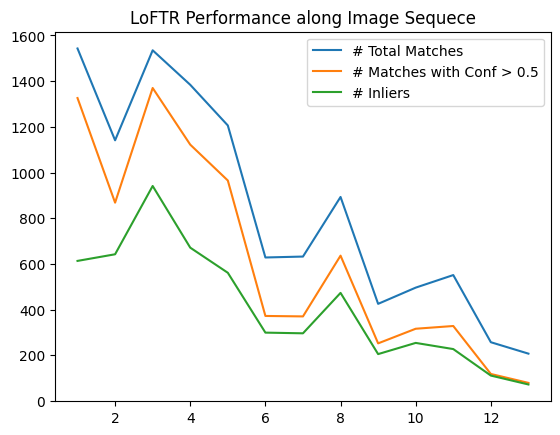

In [12]:
plt.plot(np.arange(1, len(paths)+1), n_matches, label="# Total Matches")
plt.plot(np.arange(1, len(paths)+1), n_conf_matches, label="# Matches with Conf > 0.5")
plt.plot(np.arange(1, len(paths)+1), n_inliers, label="# Inliers")
plt.legend()
plt.title("LoFTR Performance along Image Sequece")
plt.show()